In [12]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import R2Score

In [13]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [14]:
initialize=True

In [15]:
df = pd.read_csv('./united_data_soybean.csv', index_col=0).fillna(0)
y = df['Soybean_Yield']
X = df.drop(columns=['Soybean_Yield'], axis=1)

In [16]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Soybean_Yield'] = row['Soybean_Yield'] + (1950-year)*1.96966271
    return row
    

In [17]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Soybean_Yield']

In [18]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [20]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [22]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [24]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([308, 4, 222])
torch.Size([921, 4, 222])


## Train the model

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999

r2score = R2Score()
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)

            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            rscore = r2score(outputs.reshape(-1), y_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "lstm-adjusted-500")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item(), "Test R-squared:", rscore.item())

Epoch:  1  Train loss:  300.51007080078125 Test loss: 154.2347412109375 Test R-squared: 0.7561200857162476
Epoch:  2  Train loss:  328.618408203125 Test loss: 158.65084838867188 Test R-squared: 0.7491372227668762
Epoch:  3  Train loss:  310.446044921875 Test loss: 129.50914001464844 Test R-squared: 0.7952168583869934
Epoch:  4  Train loss:  311.2374572753906 Test loss: 129.86085510253906 Test R-squared: 0.7946606874465942
Epoch:  5  Train loss:  289.6502380371094 Test loss: 136.16046142578125 Test R-squared: 0.7846996188163757
Epoch:  6  Train loss:  310.3731384277344 Test loss: 152.503173828125 Test R-squared: 0.7588580846786499
Epoch:  7  Train loss:  298.0021057128906 Test loss: 114.25569152832031 Test R-squared: 0.8193359971046448
Epoch:  8  Train loss:  265.3260803222656 Test loss: 121.89500427246094 Test R-squared: 0.8072565197944641
Epoch:  9  Train loss:  272.6167907714844 Test loss: 103.45930480957031 Test R-squared: 0.8364075422286987
Epoch:  10  Train loss:  295.196105957031

In [32]:
outputs = model(weather_test)
rscore = r2score(outputs.reshape(-1), y_test)
rscore.item()

0.9936262965202332

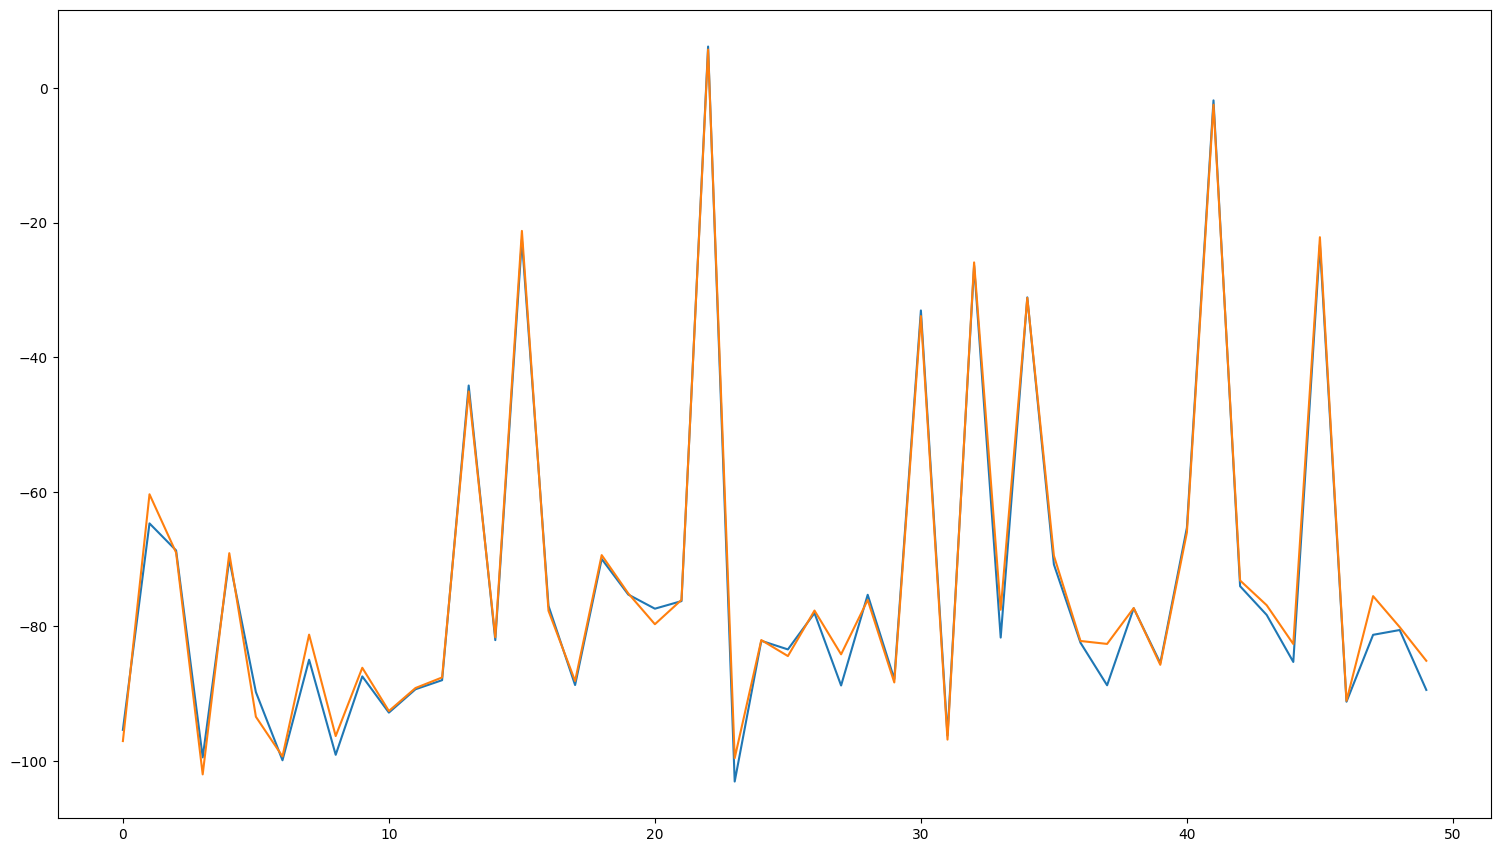

In [33]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Load and evaluate the model

In [36]:
from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

ImportError: cannot import name 'get_data_pred' from 'utils' (c:\Users\Attila\AppData\Local\Programs\Python\Python39\lib\site-packages\utils\__init__.py)

In [222]:
# outputs # of the model we trained without the adjustments

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [16]:
out # oof the model we trained with the adjustments

tensor([[114.4748],
        [ 63.8450],
        [124.6391],
        [138.7735],
        [141.8226],
        [141.1663],
        [148.0757],
        [131.5047],
        [132.3883],
        [155.8086],
        [149.0855],
        [144.8992],
        [136.4871],
        [154.3260],
        [161.6747],
        [110.9454],
        [144.0197]])

### Plot the loss

In [37]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']

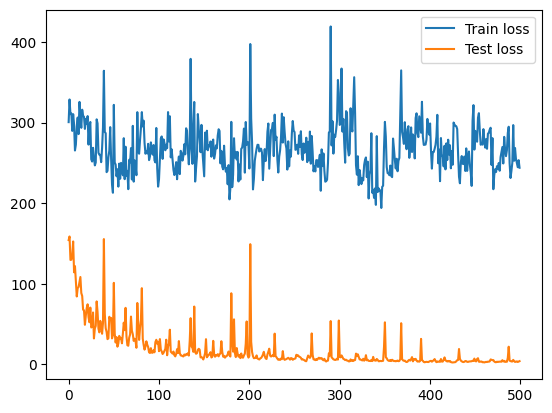

In [38]:
import matplotlib.pyplot as plt
res.plot()
plt.savefig('lstm-adjusted-500-losses.png')

<Axes: >

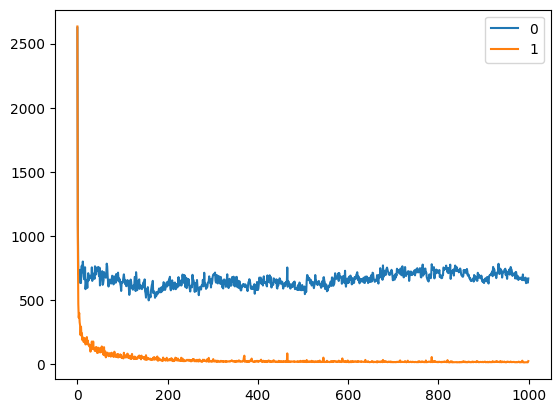

In [72]:
# res.plot() # training without adjustments 